## 6.6: Sourcing & Analyzing Time Series Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'a-TaAo4zNZ-rzywvMmJQ'

In [3]:
# Importing the Inflation Rates in Europe, Germany --> RATEINF/CPI_DEU

data = quandl.get('RATEINF/CPI_DEU')

In [4]:
data.head()

,Value
Date,
1991-01-31,64.0
1991-02-28,64.3
1991-03-31,64.3
1991-04-30,64.5
1991-05-31,64.7


In [5]:
data.describe()

,Value
count,391.000000
mean,89.051662
std,12.264974
min,64.000000
25%,78.600000
50%,89.300000
75%,99.700000
max,117.100000


## 01. Cearing a subset including historical events

I would take the following period of time: 2002 - present

Motivation: To understand how the inflation rates have changed since the introduction of the euro as the main currency in Europe.

Global events:
- The Euro Introduction (2002)
- Global Financial Crisis (2008-2009)
- COVID-19 Pandemic (2020 - present)
- Ukraie war (24 February 2022 - present)

In [6]:
data.shape

(391, 1)

In [7]:
type(data)

pandas.core.frame.DataFrame

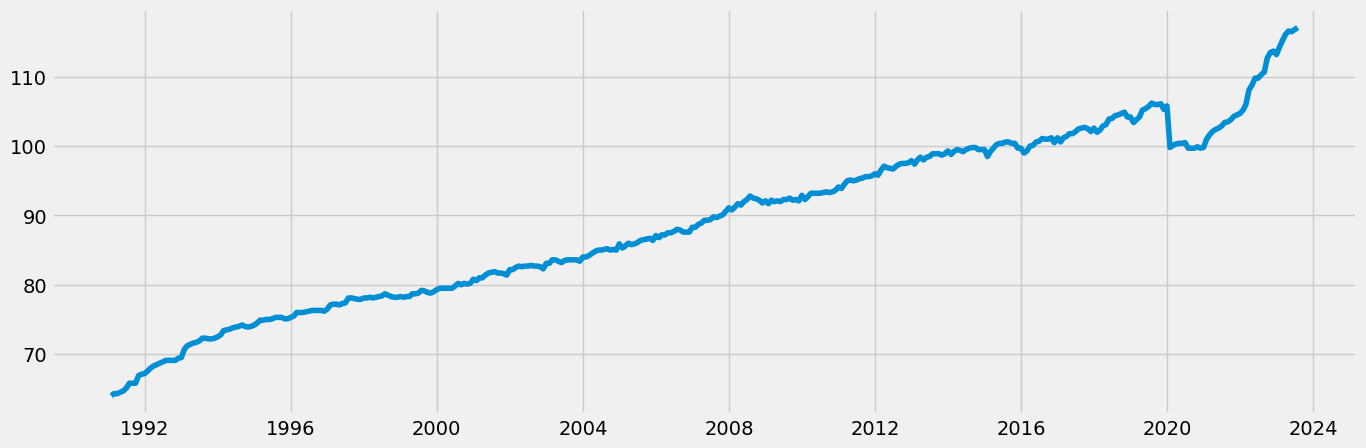

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

- At first glance, it is clear from the graph that the inflation rate steadily increased every year. There was a decline in 2020 (the year the COVID pandemic began), and then it started rising again with even greater strength.

## 02. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1991-01-31,64.0
1,1991-02-28,64.3
2,1991-03-31,64.3
3,1991-04-30,64.5
4,1991-05-31,64.7


In [11]:
# Check for missing values (you shouldn't have any)

data_2.isnull().sum() 

Date     0
Value    0
dtype: int64

In [12]:
# Check for duplicates

dups = data_2.duplicated()
dups.sum()

0

In [13]:
data_2.shape

(391, 2)

In [14]:
data_2['Date'].value_counts()

1991-01-31    1
2011-06-30    1
2013-04-30    1
2013-03-31    1
2013-02-28    1
             ..
2001-09-30    1
2001-08-31    1
2001-07-31    1
2001-06-30    1
2023-07-31    1
Name: Date, Length: 391, dtype: int64

In [15]:
# Substetting

data_sub = data_2.loc[(data_2['Date'] >= '2002-01-01') & (data_2['Date'] < '2023-07-31')]

In [16]:
data_sub.shape

(258, 2)

In [17]:
data_sub.head()

,Date,Value
132,2002-01-31,82.2
133,2002-02-28,82.5
134,2002-03-31,82.7
135,2002-04-30,82.6
136,2002-05-31,82.7


In [18]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2002-01-31,82.2
2002-02-28,82.5
2002-03-31,82.7
2002-04-30,82.6
2002-05-31,82.7


In [19]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

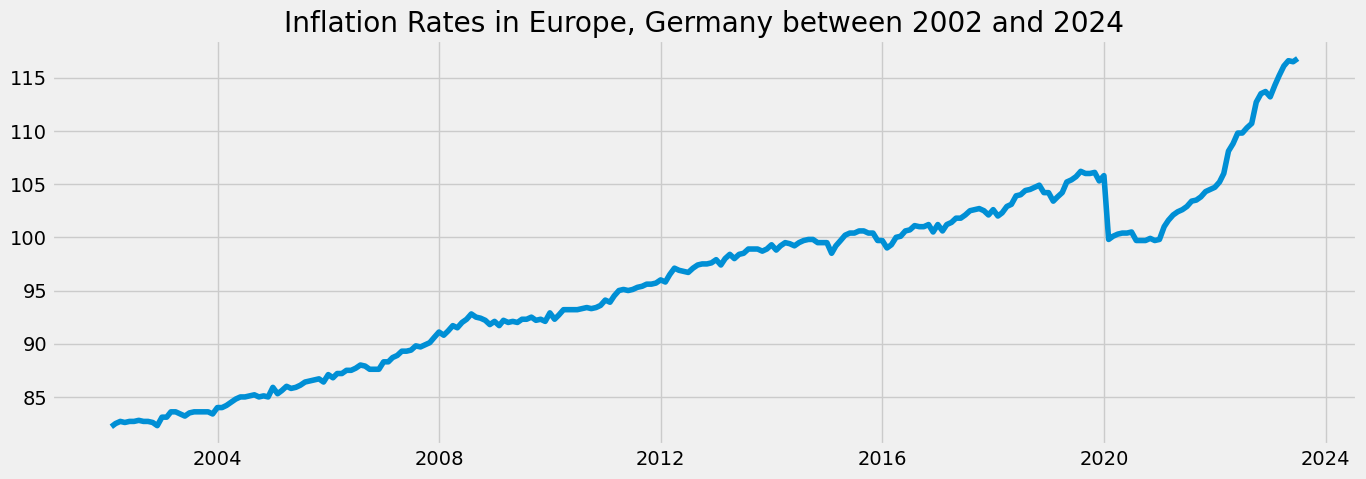

In [20]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)
plt.title('Inflation Rates in Europe, Germany between 2002 and 2024')
plt.show()

## 03. Time-series analysis: decomposition

In [22]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [23]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

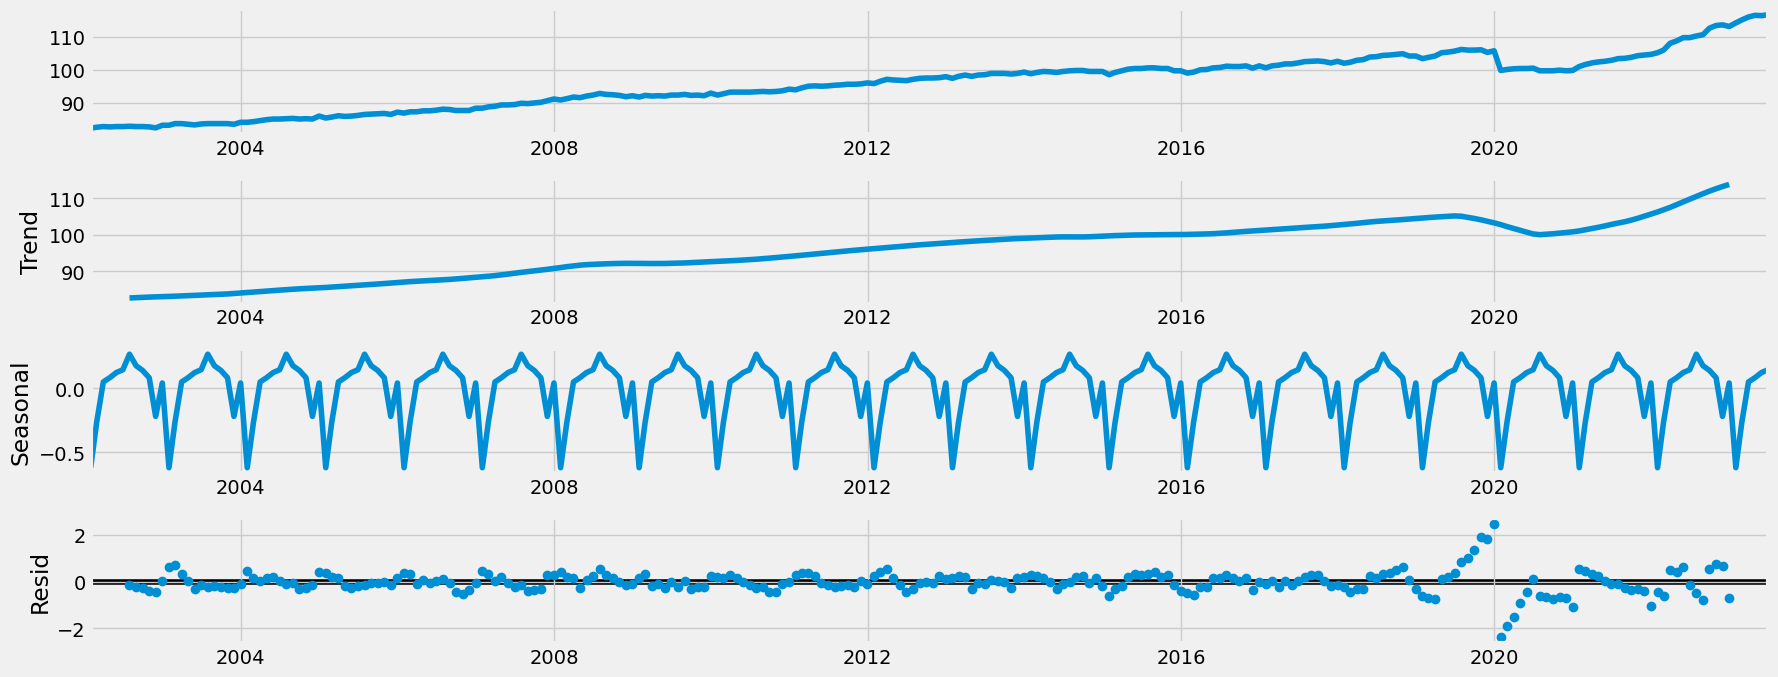

In [24]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Comments:

- It seems that the data has no stationarity.
- There is not a big difference between the trendline and the data itself.
- There is a clear seasonality.
- There is much noise in the year 2020 and after.

## 04. Testing for stationarity

In [25]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.877786
p-value                          0.992793
Number of Lags Used              2.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
dtype: float64


#### Comments:

- H0: There is a unit root in this dataset. 
- Test statistic (.99) is larger than critical value for 5% (-2.87) -> H0 can’t be rejected

=> That there is a unit root in the data, and the data is non-stationary.

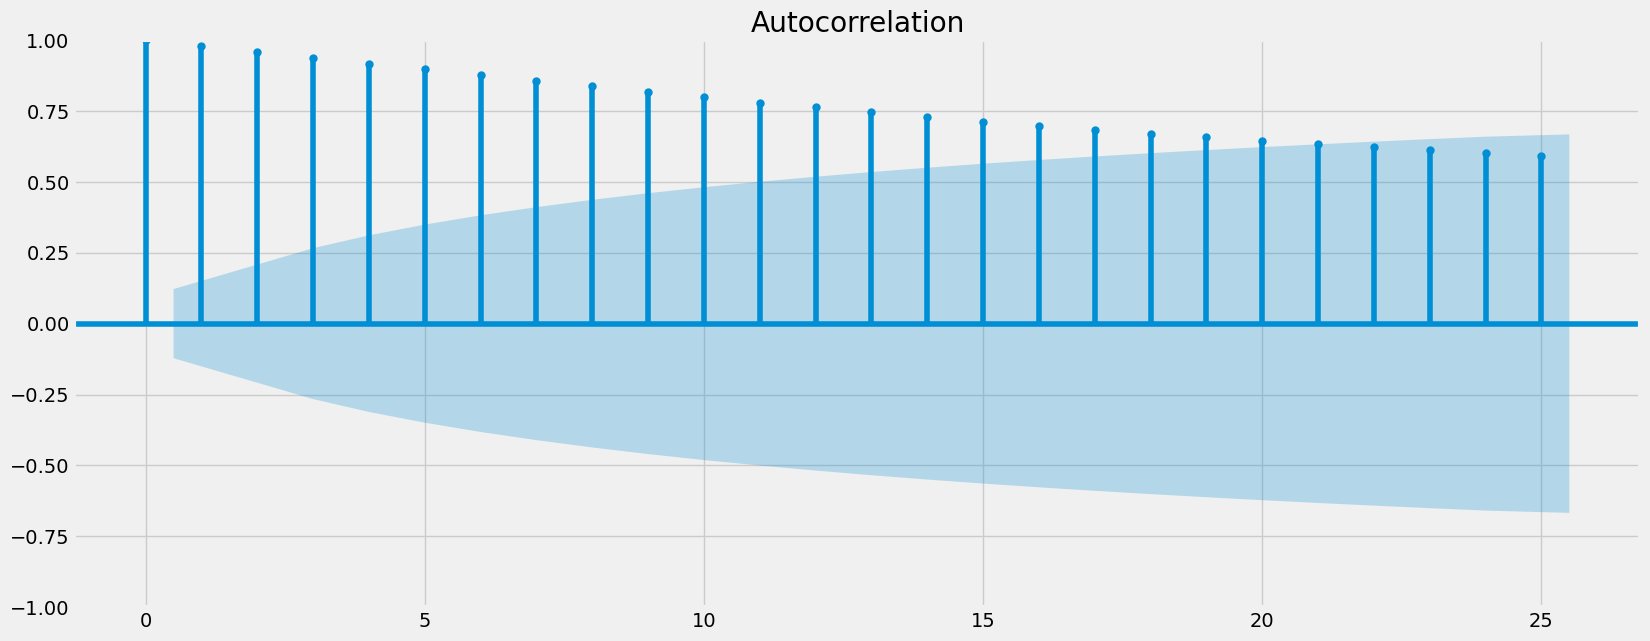

In [26]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

## Comments:

- The lines go above the blue edge of the confidence interval, what means that there are lags that are significantly correlated with each other. 

## 05. Stationarizing the data

In [27]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [28]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [29]:
data_diff.head()

,Value
datetime,
2002-02-28,0.3
2002-03-31,0.2
2002-04-30,-0.1
2002-05-31,0.1
2002-06-30,0.0


In [30]:
data_diff.columns

Index(['Value'], dtype='object')

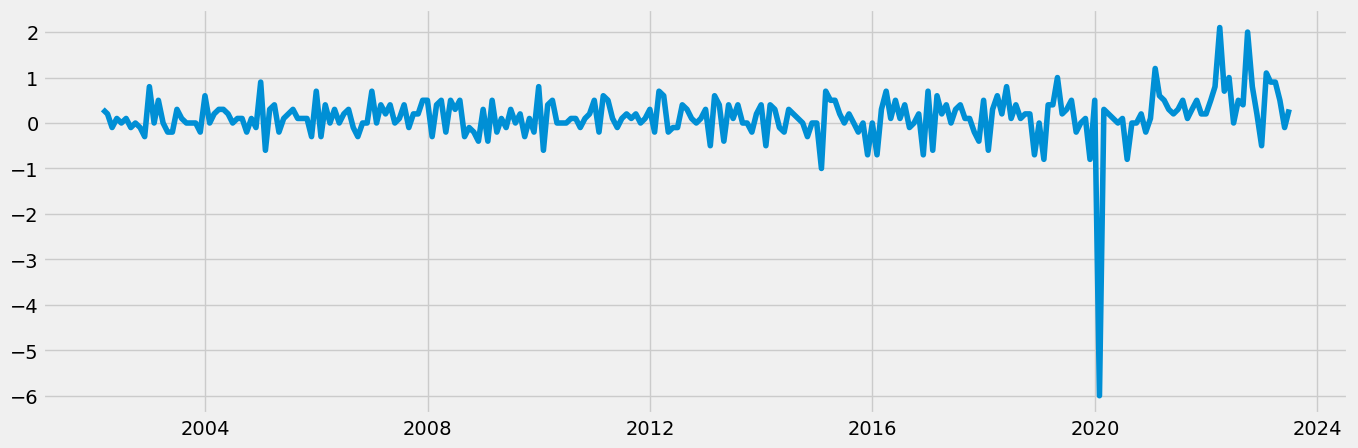

In [31]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [33]:
# Change the format of the values visualization

pd.options.display.float_format = '{:.2f}'.format

# Dickey Fuller test

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -9.49
p-value                         0.00
Number of Lags Used             1.00
Number of Observations Used   255.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


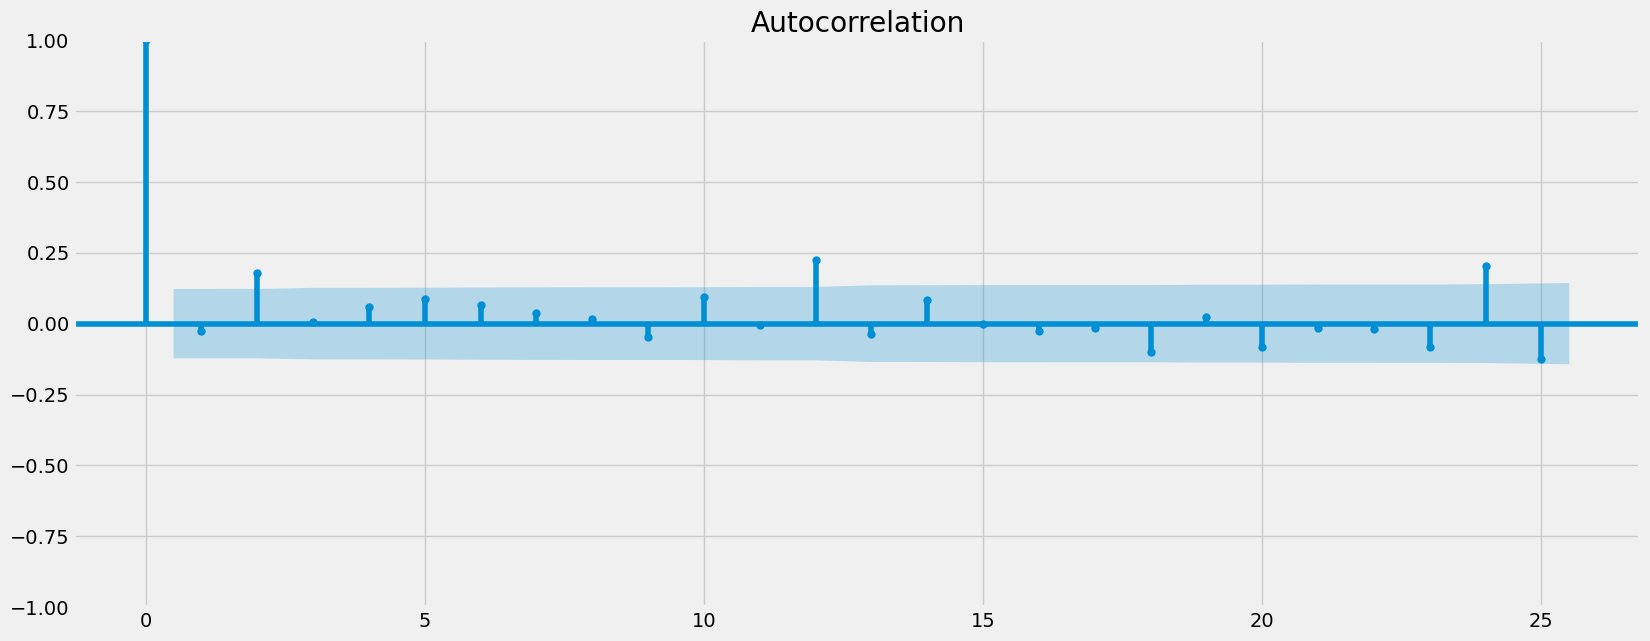

In [34]:
plot_acf(data_diff)
plt.show()

#### Comments:

H0: There is a unit root in this dataset.
- Test statistic (.00) is larger than critical value for 5% (-2.87) -> H0 still can’t be rejected => The data is non-stationary.

- There are still some lines that go above the blue edge of the confidence interval, which means that there are lags that are significantly correlated with each other.

## 06. Repeating the step 5

In [35]:
data_diff_1 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [36]:
data_diff_1.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [40]:
data_diff_1.head()

,Value
datetime,
2002-03-31,-0.10
2002-04-30,-0.30
2002-05-31,0.20
2002-06-30,-0.10
2002-07-31,0.10


In [38]:
data_diff.shape

(257, 1)

In [41]:
data_diff_1.columns

Index(['Value'], dtype='object')

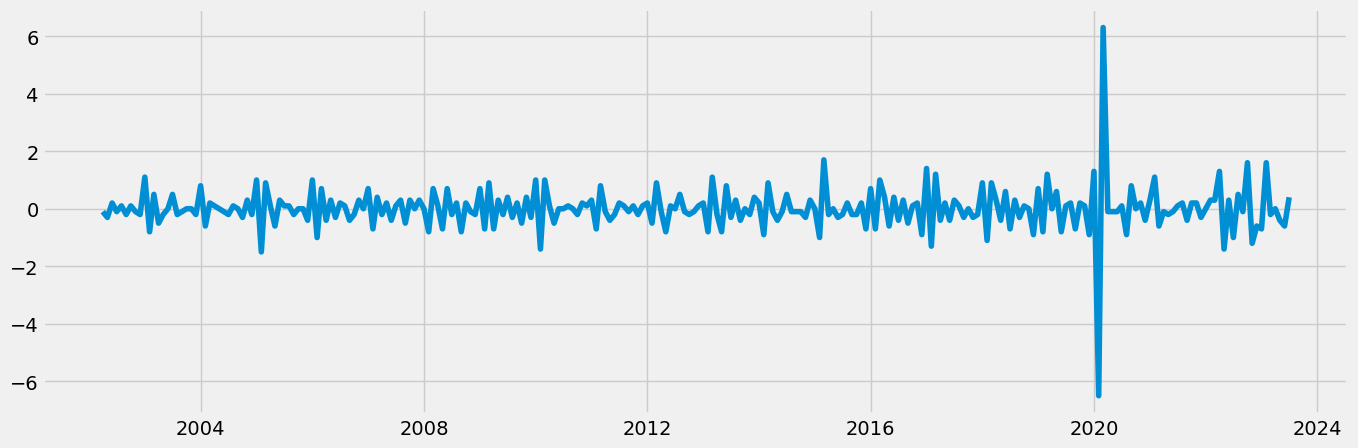

In [42]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_1)

In [44]:
# Change the format of the values visualization

pd.options.display.float_format = '{:.2f}'.format

# Dickey Fuller test

dickey_fuller(data_diff_1)

Dickey-Fuller Stationarity test:
Test Statistic                 -9.35
p-value                         0.00
Number of Lags Used            10.00
Number of Observations Used   245.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


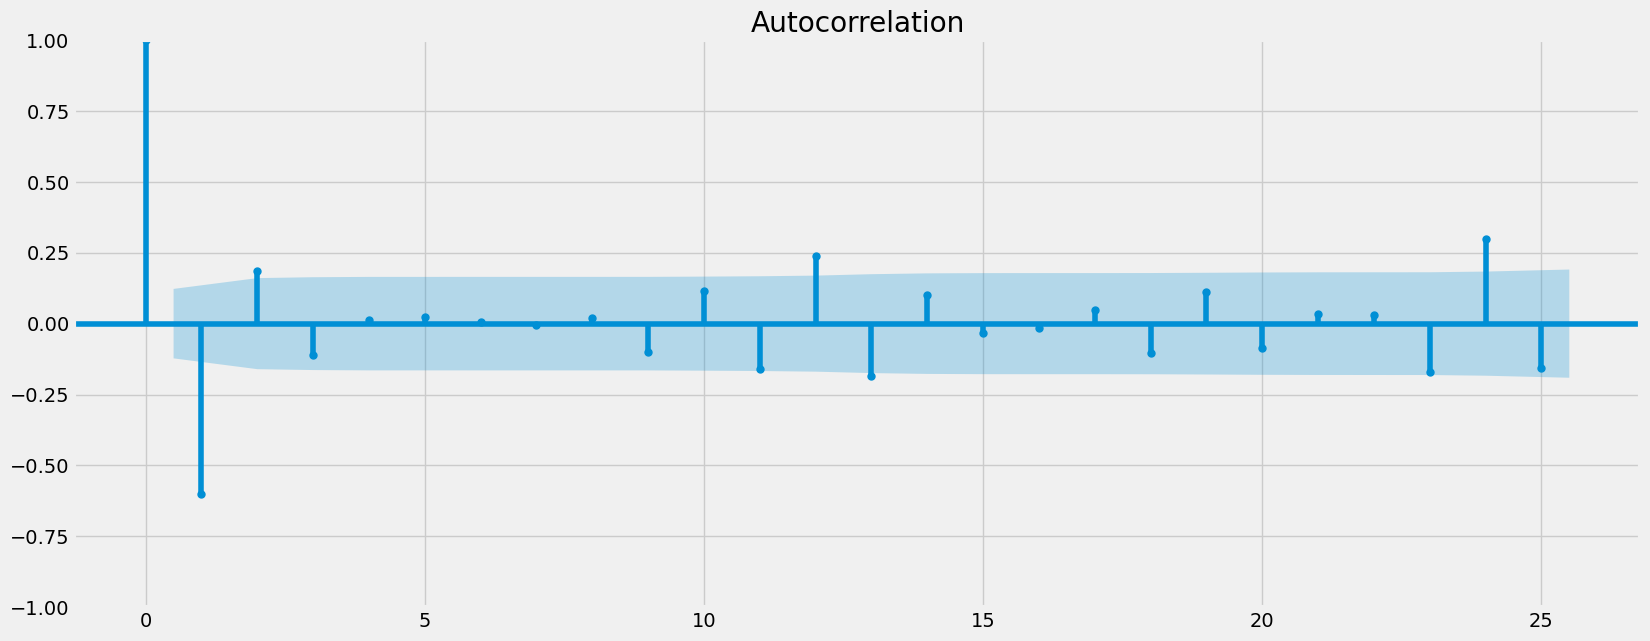

In [45]:
plot_acf(data_diff_1)
plt.show()

#### Conclusion:

- There are still the same issues with autocorrelation and stationarity.
- Interesting is how the inflation rates have changed during the COVID pandemic (2020): initially a sharp drop, then a high rise.